## Imports

In [258]:
from sklearn.preprocessing  import RobustScaler
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.preprocessing  import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import pandas as pd
import seaborn as sns
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="ticks")
random_state = 42

Load data

In [126]:
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test_ID = test.PassengerId

Proprocessing

In [127]:
def preprocess(df, fit, oh_enc, ordinal_enc):
    df["Deck"] = pd.DataFrame(df.Cabin.str.extract("([A-Z])", expand=False))
    categorical_cols = ["Sex", "Embarked"]
    drop_cols = ["Ticket", "Cabin", "Name", "PassengerId", "Sex", "Embarked", "Deck"]

    if fit:
        df = pd.concat([df, pd.DataFrame(oh_enc.fit_transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.fit_transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    else:
        df = pd.concat([df, pd.DataFrame(oh_enc.transform(df[categorical_cols].astype("str")))], axis=1)
        df = pd.concat([df, pd.DataFrame(ordinal_enc.transform(np.array(df.Deck).reshape(-1,1)))], axis=1)

    df.drop(labels=drop_cols, axis=1, inplace=True)
    df.fillna(-1, inplace=True)
    return (df)

In [128]:
oh_enc = OneHotEncoder(sparse=False)
ordinal_enc = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T", np.nan]])

train = preprocess(train, fit=True, oh_enc=oh_enc, ordinal_enc=ordinal_enc)
test = preprocess(test, fit=False, oh_enc=oh_enc, ordinal_enc=ordinal_enc)

In [129]:
train_y = train.Survived
train_X = train.drop("Survived", axis=1)

In [149]:
estimators = [
    ("knnc", KNeighborsClassifier(
        weights="distance",
        n_neighbors=100,
        n_jobs=-1
    )),
    ("gpc", GaussianProcessClassifier(
        random_state=random_state,
        warm_start=True
    )),
    ("rfc", RandomForestClassifier(
        random_state=random_state,
        class_weight="balanced_subsample",
        n_jobs=-1
    )),
    ("SVC", LinearSVC(
        max_iter=100000,
        random_state=random_state
    )),
    ("gnb", GaussianNB())
]

In [246]:
scaler = RobustScaler(
    unit_variance=True
)

reducer = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    target_weight=0.5,
    metric="correlation",
    random_state=random_state
)

class_comp = StackingClassifier(
    estimators=estimators,
    # final_estimator=final_estimator,
    n_jobs=-1,
    verbose=0,
)

In [247]:
pipeline = make_pipeline(
    scaler,
    reducer,
    class_comp
)

In [248]:
pipeline.fit(
    X=train_X,
    y=train_y
)

pred_y = pipeline.predict(test)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [249]:
proba = 1 - 2 * np.sqrt(
    np.product(
        pipeline.predict_proba(test), axis=1))


C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Plot training data

<AxesSubplot:>

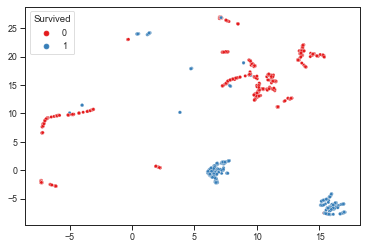

In [251]:
sns.scatterplot(
    x=pipeline["umap"].embedding_[:,0],
    y=pipeline["umap"].embedding_[:,1],
    hue=train_y,
    # alpha=proba,
    palette="Set1",
    s=10
)

Plot test data

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\seaborn\relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


<AxesSubplot:>

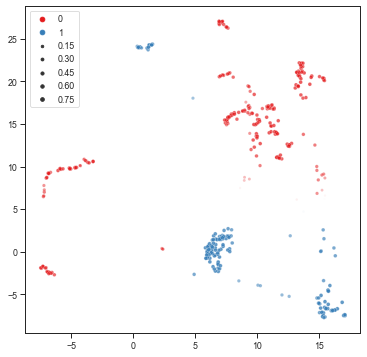

In [262]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=pipeline[:2].transform(X=test)[:,0],
    y=pipeline[:2].transform(X=test)[:,1],
    hue=pred_y,
    palette="Set1",
    size=proba,
    alpha=proba,
    sizes=(5, 15),
    s=10
)

<AxesSubplot:ylabel='Count'>

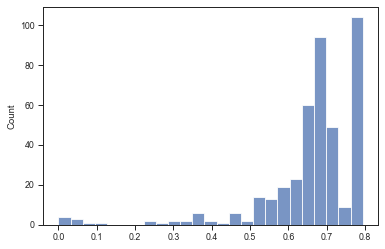

In [263]:
sns.histplot(proba)

Save predictions as csv

In [254]:
submission = pd.DataFrame(columns=["PassengerId", "Survived"], data=zip(test_ID, pred_y))
submission.to_csv("submission.csv", index=False)

In [255]:
data = pd.read_csv("data\\train.csv")
X_data = data.drop("Survived", axis=1)
y_data = data.Survived

X_train, X_test, y_train, y_test = train_test_split(
    X_data, 
    y_data,
    random_state=random_state)

In [256]:
X_train = preprocess(X_train, fit=True)

TypeError: preprocess() missing 2 required positional arguments: 'oh_enc' and 'ordinal_enc'